# Section 1: Setup and Imports

This section imports all required libraries and utility functions for training the GCN model, and sets up the device and paths for model saving and epoch tracking.


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn.functional as F
from torch_geometric.utils import degree
from sklearn.model_selection import train_test_split
from collections import Counter

from src.data_utils import load_and_preprocess_elliptic_data
from src.model_gcn import GCNNet
from src.train_gcn import train, evaluate

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
model_dir = "../models/GCN"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, "best_model.pth")
epoch_tracker_path = os.path.join(model_dir, "epoch_counter.txt")


Using device: cpu


# Section 2: Load and Preprocess Data

Load the Elliptic Bitcoin dataset using the pre-built utility. This automatically handles:
- Mapping transaction IDs to node indices
- Assigning class labels (licit/illicit)
- Normalizing features
- Removing isolated nodes from the graph

In [3]:
# Cell 2: Load and preprocess the dataset

data = load_and_preprocess_elliptic_data()
print(data)

# Confirm class label distribution
label_mask = data.y != -1
print("Labeled class distribution:", Counter(data.y[label_mask].tolist()))


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])
Labeled class distribution: Counter({1: 42019, 0: 4545})


# Section 3: Train/Validation Split

Perform a stratified split on the labeled nodes to ensure balanced class representation between training and validation sets.


In [4]:
# Cell 3: Create stratified train/val split

import numpy as np
from sklearn.model_selection import train_test_split

# Only use nodes with known labels
labeled_indices = torch.where(data.y != -1)[0]
labels = data.y[labeled_indices].cpu().numpy()

train_idx, val_idx = train_test_split(
    labeled_indices.cpu().numpy(),
    test_size=0.3,
    random_state=42,
    stratify=labels
)

train_idx = torch.tensor(train_idx, dtype=torch.long).to(device)
val_idx = torch.tensor(val_idx, dtype=torch.long).to(device)

print("Train class balance:", Counter(data.y[train_idx].cpu().numpy()))
print("Val class balance:", Counter(data.y[val_idx].cpu().numpy()))


Train class balance: Counter({np.int64(1): 29413, np.int64(0): 3181})
Val class balance: Counter({np.int64(1): 12606, np.int64(0): 1364})


# Section 4: Initialize the GCN Model

This step creates the GCN architecture and moves it to the appropriate device. The model is defined in `src/model_gcn.py` with two layers and ReLU + dropout in between.


In [5]:
# Cell 4: Instantiate the GCN model

model = GCNNet(
    in_channels=data.x.shape[1],
    hidden_channels=16,
    out_channels=2,
    dropout=0.3
).to(device)

print(model)


GCNNet(
  (conv1): GCNConv(166, 16)
  (conv2): GCNConv(16, 2)
)


# Section 5: Train GCN Model with Early Stopping

Train the GCN model for up to 200 epochs with early stopping and learning rate scheduling. Track the best validation accuracy and update an epoch counter to enable multi-session training.

In [6]:
# Cell 5: Train the model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Epoch tracking setup
if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, "r") as f:
        epoch_offset = int(f.read().strip())
        print(f"Continuing from epoch offset: {epoch_offset}")
else:
    epoch_offset = 0
    print("Starting fresh — epoch offset = 0")

num_epochs = 200
patience = 20
best_val_acc = 0
best_epoch = 0
counter = 0
loss_history = []
val_history = []

for epoch in range(num_epochs):
    loss = train(model, data, train_idx, optimizer)
    acc = evaluate(model, data, val_idx)
    scheduler.step(loss)

    loss_history.append(loss)
    val_history.append(acc)

    print(f"Epoch {epoch}: Loss = {loss:.4f}, Val Acc = {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        best_epoch = epoch
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"→ Best model saved (Val Acc = {acc:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Update total epochs trained
total_epochs = epoch_offset + best_epoch
with open(epoch_tracker_path, "w") as f:
    f.write(str(total_epochs))

print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Total epochs trained so far: {total_epochs}")

Starting fresh — epoch offset = 0
Epoch 0: Loss = 1.8524, Val Acc = 0.2560
→ Best model saved (Val Acc = 0.2560)
Epoch 1: Loss = 1.7166, Val Acc = 0.2820
→ Best model saved (Val Acc = 0.2820)
Epoch 2: Loss = 1.6476, Val Acc = 0.3077
→ Best model saved (Val Acc = 0.3077)
Epoch 3: Loss = 1.6204, Val Acc = 0.3321
→ Best model saved (Val Acc = 0.3321)
Epoch 4: Loss = 1.4780, Val Acc = 0.3526
→ Best model saved (Val Acc = 0.3526)
Epoch 5: Loss = 1.3728, Val Acc = 0.3757
→ Best model saved (Val Acc = 0.3757)
Epoch 6: Loss = 1.2752, Val Acc = 0.3953
→ Best model saved (Val Acc = 0.3953)
Epoch 7: Loss = 1.2415, Val Acc = 0.4188
→ Best model saved (Val Acc = 0.4188)
Epoch 8: Loss = 1.1193, Val Acc = 0.4429
→ Best model saved (Val Acc = 0.4429)
Epoch 9: Loss = 1.0338, Val Acc = 0.4641
→ Best model saved (Val Acc = 0.4641)
Epoch 10: Loss = 1.0488, Val Acc = 0.4858
→ Best model saved (Val Acc = 0.4858)
Epoch 11: Loss = 0.9632, Val Acc = 0.5059
→ Best model saved (Val Acc = 0.5059)
Epoch 12: Loss =

# Section 6: Resume Training from Saved Model (Optional)

Resume training the GCN model from the last best checkpoint. This is useful for micro-optimizing performance across multiple sessions without retraining from scratch.


In [8]:
# Re-instantiate the model
resumed_model = GCNNet(
    in_channels=data.x.shape[1],
    hidden_channels=16,
    out_channels=2,
    dropout=0.3
).to(device)

# Load checkpoint
if os.path.exists(best_model_path):
    resumed_model.load_state_dict(torch.load(best_model_path))
    print("Loaded existing best_model.pth")
else:
    print("No existing model found. Starting from scratch.")

# Load previous epoch count
if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, "r") as f:
        resume_epoch_offset = int(f.read().strip())
        print(f"Resuming from total epoch offset: {resume_epoch_offset}")
else:
    resume_epoch_offset = 0
    print("Starting fresh — no epoch history found")

# Resume training config
resumed_optimizer = torch.optim.Adam(resumed_model.parameters(), lr=0.001, weight_decay=5e-4)
resumed_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resumed_optimizer, mode='min', factor=0.5, patience=10)

resume_epochs = 100
resume_patience = 20
best_val_acc_resume = 0
resume_best_epoch = 0
patience_counter = 0
loss_history_resume = []
val_history_resume = []

for epoch in range(resume_epochs):
    loss = train(resumed_model, data, train_idx, resumed_optimizer)
    acc = evaluate(resumed_model, data, val_idx)
    resumed_scheduler.step(loss)

    loss_history_resume.append(loss)
    val_history_resume.append(acc)

    print(f"[Resume] Epoch {epoch}: Loss = {loss:.4f}, Val Acc = {acc:.4f}")

    if acc > best_val_acc_resume:
        best_val_acc_resume = acc
        resume_best_epoch = epoch
        patience_counter = 0
        torch.save(resumed_model.state_dict(), best_model_path)
        print(f"→ Best resumed model saved (Val Acc = {acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= resume_patience:
            print("Early stopping (resumed training) triggered.")
            break

# Update epoch counter
total_epochs_trained = resume_epoch_offset + resume_best_epoch
with open(epoch_tracker_path, "w") as f:
    f.write(str(total_epochs_trained))

print(f"Best resumed validation accuracy: {best_val_acc_resume:.4f} at resumed epoch {resume_best_epoch}")
print(f"Total epochs trained across sessions: {total_epochs_trained}")


Loaded existing best_model.pth
Resuming from total epoch offset: 199
[Resume] Epoch 0: Loss = 0.2332, Val Acc = 0.9175
→ Best resumed model saved (Val Acc = 0.9175)
[Resume] Epoch 1: Loss = 0.2338, Val Acc = 0.9178
→ Best resumed model saved (Val Acc = 0.9178)
[Resume] Epoch 2: Loss = 0.2331, Val Acc = 0.9184
→ Best resumed model saved (Val Acc = 0.9184)
[Resume] Epoch 3: Loss = 0.2324, Val Acc = 0.9188
→ Best resumed model saved (Val Acc = 0.9188)
[Resume] Epoch 4: Loss = 0.2303, Val Acc = 0.9191
→ Best resumed model saved (Val Acc = 0.9191)
[Resume] Epoch 5: Loss = 0.2309, Val Acc = 0.9192
→ Best resumed model saved (Val Acc = 0.9192)
[Resume] Epoch 6: Loss = 0.2308, Val Acc = 0.9193
→ Best resumed model saved (Val Acc = 0.9193)
[Resume] Epoch 7: Loss = 0.2255, Val Acc = 0.9195
→ Best resumed model saved (Val Acc = 0.9195)
[Resume] Epoch 8: Loss = 0.2266, Val Acc = 0.9200
→ Best resumed model saved (Val Acc = 0.9200)
[Resume] Epoch 9: Loss = 0.2256, Val Acc = 0.9203
→ Best resumed mo

# Section 7: Final Evaluation (F1, ROC-AUC, PR-AUC)

This step evaluates the best trained GCN model on the validation set using standard classification metrics: F1 score, ROC AUC, PR AUC, and per-class recall.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Inference
with torch.no_grad():
    logits = model(data.x.to(device), data.edge_index.to(device))[val_idx]
    preds = logits.argmax(dim=1).cpu()
    probs = torch.exp(logits)[:, 1].cpu()  # Probability of class 1 (illicit)

y_true = data.y[val_idx].cpu()

# Metrics
f1 = f1_score(y_true, preds, average='macro')
roc_auc = roc_auc_score(y_true, probs)
pr_auc = average_precision_score(y_true, probs)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, preds, digits=4))

# Print individual metrics
print(f"F1 Score:     {f1:.4f}")
print(f"ROC AUC:      {roc_auc:.4f}")
print(f"PR AUC:       {pr_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0     0.8257    0.5139    0.6335      1364
           1     0.9495    0.9883    0.9685     12606

    accuracy                         0.9419     13970
   macro avg     0.8876    0.7511    0.8010     13970
weighted avg     0.9374    0.9419    0.9358     13970

F1 Score:     0.8010
ROC AUC:      0.9349
PR AUC:       0.9909


# Section 8: Visualize Training Loss, Accuracy, ROC & PR Curves

Plot training loss and validation accuracy over epochs, as well as the ROC and precision-recall curves for the final model on the validation set.

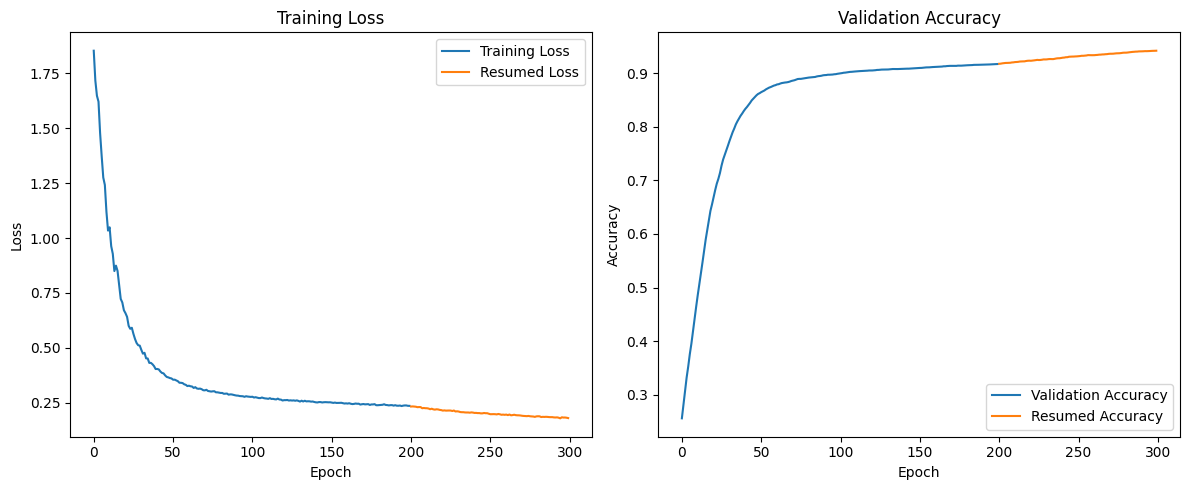

In [16]:
# Cell 8a: Plot training loss and validation accuracy

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Training Loss")
if 'loss_history_resume' in globals():
    plt.plot(range(len(loss_history), len(loss_history) + len(loss_history_resume)), loss_history_resume, label="Resumed Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_history, label="Validation Accuracy")
if 'val_history_resume' in globals():
    plt.plot(range(len(val_history), len(val_history) + len(val_history_resume)), val_history_resume, label="Resumed Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


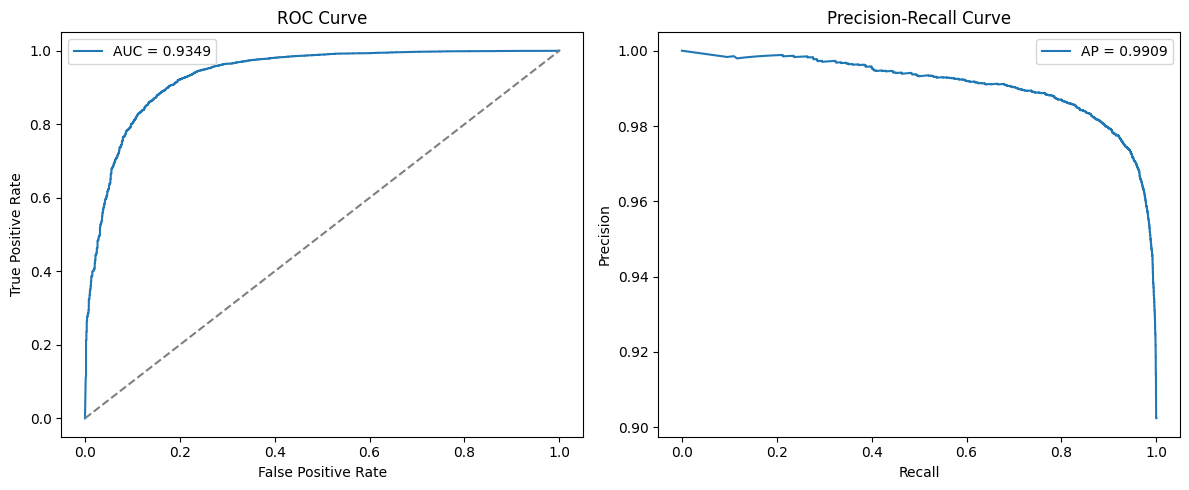

In [17]:
# Cell 8b: ROC and PR curves

from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, probs)
precision, recall, _ = precision_recall_curve(y_true, probs)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()
